In [12]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from layers import *
from approach1 import *
from solver import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
raw = pickle.load(open("stories.pck", "rb"))
print len(raw), "examples"
print max([len(x) for x in raw]), "supporting facts and questions at most"
print max([len(y.split(' ')) for y in x for x in raw]), "words per sentence at most"

_null, _start, _query, _end = "<NULL>", "<Start>", "<Query>", "<End>"

words = [_null, _start, _query, _end] + [q for ex in raw for sent in ex for w in sent.split(' ') for q in w.split(',')]
words = sorted(set(words))
word_to_idx = {w:i for i,w in enumerate(words)}

print len(words), "total words"

T = 70 # longest story, 35 words unfolding
T2= 7

data = []
for ex in raw:
    sLen = 0
    while ex[sLen].find(',')==-1:
        sLen+=1
    supports = word_to_idx[_null] * np.ones(T, dtype=int)
    queries = word_to_idx[_null] * np.ones((len(ex)-sLen, 5), dtype=int)
    
    pos=0
    for idx, sent in enumerate(ex):
        if idx<sLen:
            sent = [word_to_idx[_start]] + [word_to_idx[x] for x in sent.split(' ')] + [word_to_idx[_end]]
            supports[pos:pos+T2] = sent +  [word_to_idx[_null]]*(T2-len(sent))
            pos += T2
        else:
            sent = sent.split(',')[0]
            sent = [word_to_idx[_query]] + [word_to_idx[x] for x in sent.split(' ')] + [word_to_idx[_end]]
            sent = sent + [word_to_idx[_null]]*(5-len(sent)) #null pad the sentence
            queries[idx-sLen, :] = sent
    
    answers = np.asarray([word_to_idx[x.split(',')[1]] for x in ex[sLen:]]).reshape(len(ex)-sLen, 1)
    for i in xrange(queries.shape[0]):
        data.append(np.hstack((supports, queries[i,:], answers[i,:])))

data = np.asarray(data)
data_train = data[:-1000,:]
data_test = data[-1000:,:]
print data_train.shape

1000 examples
14 supporting facts and questions at most
5 words per sentence at most
159 total words
(3275, 76)


(Iteration 1 / 400) loss: 128.258598
(Iteration 11 / 400) loss: 83.101524
(Iteration 21 / 400) loss: 75.585288
(Iteration 31 / 400) loss: 60.214240
(Iteration 41 / 400) loss: 51.096577
(Iteration 51 / 400) loss: 39.321050
(Iteration 61 / 400) loss: 33.096001
(Iteration 71 / 400) loss: 36.949717
(Iteration 81 / 400) loss: 34.117601
(Iteration 91 / 400) loss: 20.690696
(Iteration 101 / 400) loss: 27.330980
(Iteration 111 / 400) loss: 25.262987
(Iteration 121 / 400) loss: 19.611419
(Iteration 131 / 400) loss: 17.353488
(Iteration 141 / 400) loss: 15.824165
(Iteration 151 / 400) loss: 10.340389
(Iteration 161 / 400) loss: 7.727202
(Iteration 171 / 400) loss: 4.228136
(Iteration 181 / 400) loss: 3.295185
(Iteration 191 / 400) loss: 2.525980
(Iteration 201 / 400) loss: 3.267241
(Iteration 211 / 400) loss: 1.748517
(Iteration 221 / 400) loss: 1.858967
(Iteration 231 / 400) loss: 2.187652
(Iteration 241 / 400) loss: 2.311466
(Iteration 251 / 400) loss: 1.437305
(Iteration 261 / 400) loss: 1.28

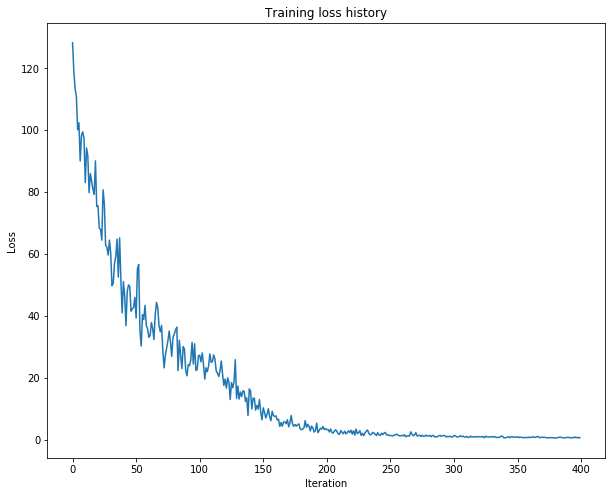

In [21]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=256, wordvec_dim=512, sentlen=T2, storylen=T, qlen=5)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=200,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [36]:
minibatch = data_train[:50]
print "Train:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()

story=" ".join([words[x] for x in data_train[0,:T]]).split(_null)
for x in story:
  if len(x.split(' '))>2:
    print x.strip()
i=0
while np.all(data_train[0,:T]==data_train[i,:T]):
  print " ".join([words[x] for x in data_train[i,T:T+6]])
  i=i+1

print
print "Other answers:"
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 1.0
<Start> hasan parka gitti . <End>
<Start> sinan eva gitti . <End>
<Start> hasan servisa gitti . <End>
<Start> emre tershanea gitti . <End>
<Start> ali boluma gitti . <End>
<Query> hasan nerede ? <End> servis
<Query> sinan nerede ? <End> ev
<Query> emre nerede ? <End> tershane
<Query> ali nerede ? <End> bolum

Other answers:
servis servis
ev ev
tershane tershane
bolum bolum
kantin kantin
kantin kantin
kamyon kamyon
ev ev
araba araba
labaratuvar labaratuvar
araba araba
kantin kantin
masa masa
sira sira
masa masa
lastikci lastikci
lastikci lastikci
otobus otobus
otobus otobus
okul okul
hastane hastane
tamirhane tamirhane
tamirhane tamirhane
sandalye sandalye
hastane hastane
servis servis
hastane hastane
tuvalet tuvalet
tuvalet tuvalet
tuvalet tuvalet
tuvalet tuvalet
masa masa
oda oda
servis servis
kamyon kamyon
dersane dersane
sinif sinif
sinif sinif
sinif sinif
dersane dersane
oda oda
banyo banyo
oda oda
oda oda
oda oda
duvar duvar
dersane dersane
ev ev
ev ev
bahce bahce


In [39]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=256, wordvec_dim=512, sentlen=T2, storylen=T, qlen=5)
solver = SeqNNSolver(model, data_train,
           update_rule='adam',
           num_epochs=200,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-4,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 26200) loss: 126.616328
(Iteration 11 / 26200) loss: 108.763675
(Iteration 21 / 26200) loss: 114.036976
(Iteration 31 / 26200) loss: 94.892302
(Iteration 41 / 26200) loss: 88.620096
(Iteration 51 / 26200) loss: 87.276733
(Iteration 61 / 26200) loss: 94.296062
(Iteration 71 / 26200) loss: 86.945463
(Iteration 81 / 26200) loss: 88.694498
(Iteration 91 / 26200) loss: 88.445670
(Iteration 101 / 26200) loss: 88.684612
(Iteration 111 / 26200) loss: 83.706617
(Iteration 121 / 26200) loss: 89.479181
(Iteration 131 / 26200) loss: 88.169860
(Iteration 141 / 26200) loss: 85.719050
(Iteration 151 / 26200) loss: 83.767701
(Iteration 161 / 26200) loss: 86.055981
(Iteration 171 / 26200) loss: 83.677506
(Iteration 181 / 26200) loss: 84.988204
(Iteration 191 / 26200) loss: 86.173574
(Iteration 201 / 26200) loss: 88.236262
(Iteration 211 / 26200) loss: 84.856608
(Iteration 221 / 26200) loss: 84.126475
(Iteration 231 / 26200) loss: 83.761531
(Iteration 241 / 26200) loss: 83.311384
(Iterati

KeyboardInterrupt: 

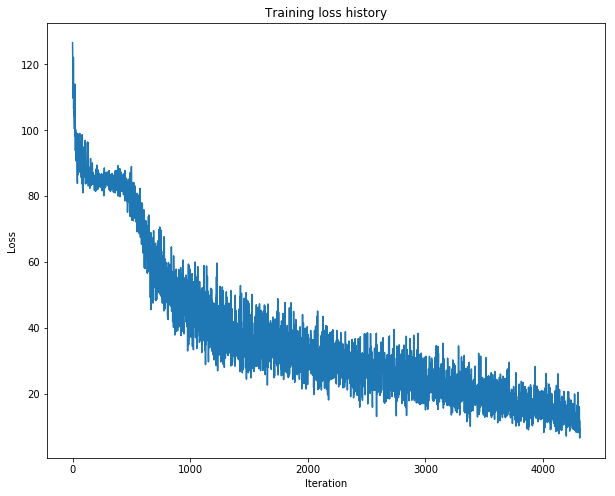

Train: 0.869
servis servis
servis ev
bolum tershane
bolum bolum
kantin kantin
kantin kantin
otobus kamyon
kantin ev
araba araba
labaratuvar labaratuvar

Test: 0.379
tamirhane bolum
tamirhane tamirhane
bolum tamirhane
araba tuvalet
araba servis
araba banyo
araba labaratuvar
araba araba
araba araba
ev servis


In [40]:
# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

print "Train:",
answ=model.loss(data_train[:1000,:], sample=True)
print (answ==data_train[:1000,-1]).mean()
minibatch = data_train[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

print
print "Test:",
answ=model.loss(data_test, sample=True)
print (answ==data_test[:,-1]).mean()
minibatch = data_test[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])